In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load the merged dataset
try:
    df = pd.read_csv("Merged_Data.csv")
    print("Dataset loaded successfully with shape:", df.shape)
    print(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")

# 2. Data Exploration
print("\n--- Dataset Overview ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Summary Statistics ---")
print(df.describe())

Dataset loaded successfully with shape: (6398, 6)
  Country Code  Year       GDP  Unemployment  Migration  Literacy
0          ABW  2000  6.519224          6.92     1226.0      16.4
1          ABW  2001  3.212406          6.90      566.0       NaN
2          ABW  2002 -1.628099          6.90      349.0       NaN
3          ABW  2003 -0.033839          6.90      329.0       NaN
4          ABW  2004  5.026912          6.90      326.0       NaN

--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  6398 non-null   object 
 1   Year          6398 non-null   int64  
 2   GDP           6288 non-null   float64
 3   Unemployment  5784 non-null   float64
 4   Migration     6360 non-null   float64
 5   Literacy      2034 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 300.0+ KB
None

--- Miss

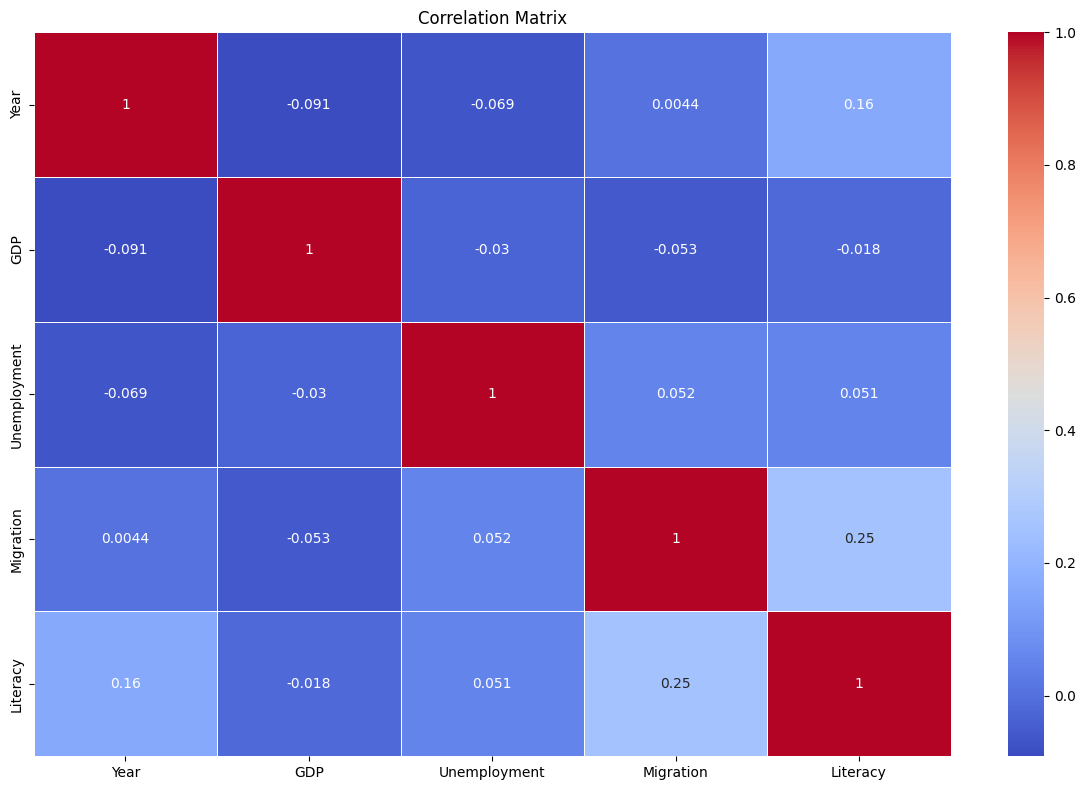

In [4]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()


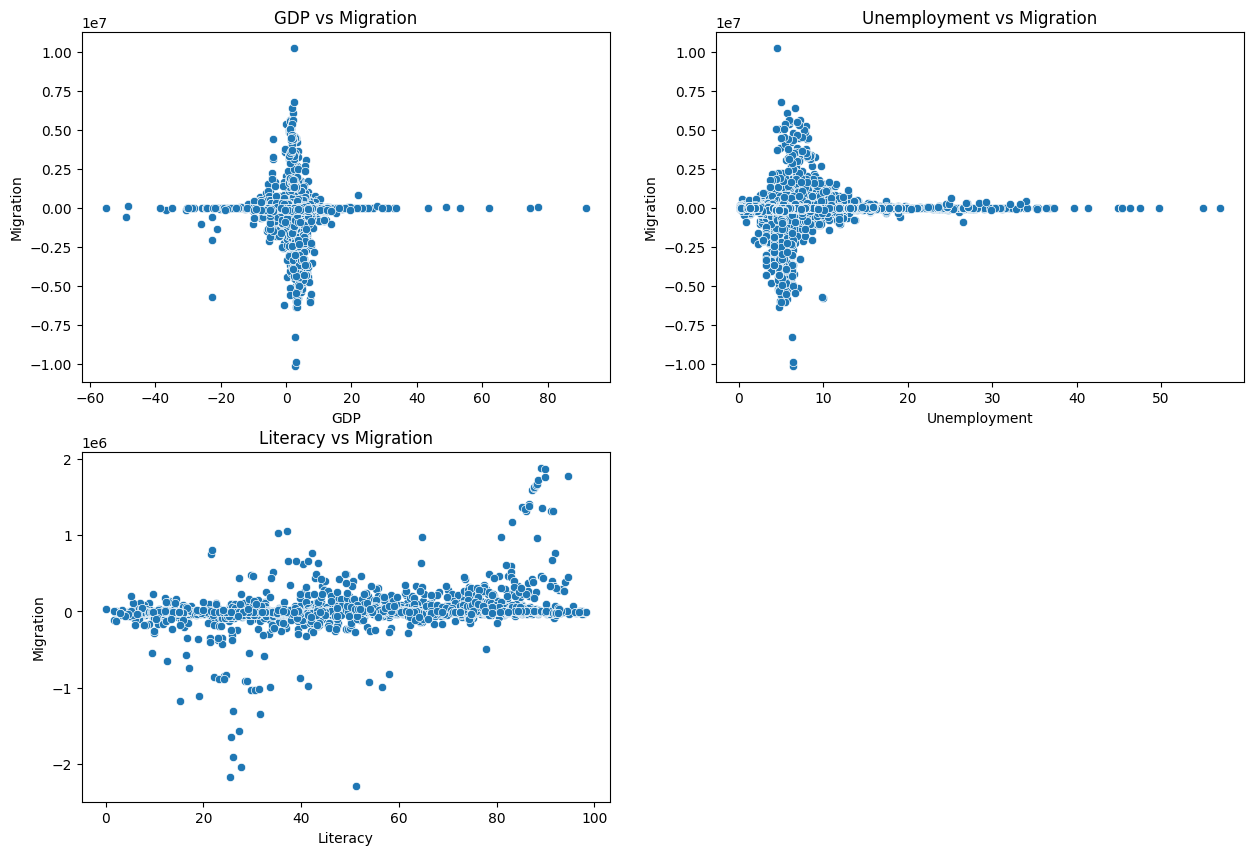

In [5]:
# Scatter plots to check relationships
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='GDP', y='Migration')
plt.title('GDP vs Migration')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Unemployment', y='Migration')
plt.title('Unemployment vs Migration')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Literacy', y='Migration')
plt.title('Literacy vs Migration')

plt.show()

plt.tight_layout()
plt.savefig('feature_relationships.png')
plt.close()

In [6]:
# 4. Data Preprocessing
print("\n--- Data Preprocessing ---")

# Handle missing values
# For this model, we'll drop rows with NaN in our target or key features
# In a production environment, more sophisticated imputation methods might be preferred
features = ['GDP', 'Unemployment', 'Literacy', 'Year']
model_df = df.dropna(subset=['Migration'] + features)
print(f"Shape after dropping NaN values: {model_df.shape}")

# Check if we have sufficient data
if len(model_df) < 100:
    print("Warning: Limited data available after dropping NaN values")
    # Alternative: impute missing values
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    
    # First, separate numeric columns
    numeric_cols = ['GDP', 'Unemployment', 'Literacy', 'Year', 'Migration']
    model_df = df.copy()
    model_df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    print(f"Shape after KNN imputation: {model_df.shape}")

# Create Country Code dummies for country-specific effects
country_dummies = pd.get_dummies(model_df['Country Code'], prefix='country')
model_df = pd.concat([model_df, country_dummies], axis=1)


--- Data Preprocessing ---
Shape after dropping NaN values: (1998, 6)


In [7]:
# 5. Feature Engineering
print("\n--- Feature Engineering ---")

# Create lag features of economic indicators
model_df['GDP_Growth'] = model_df.groupby('Country Code')['GDP'].pct_change()
model_df['Unemployment_Change'] = model_df.groupby('Country Code')['Unemployment'].diff()

# Create interaction features
model_df['GDP_Unemployment'] = model_df['GDP'] * model_df['Unemployment']
model_df['GDP_Literacy'] = model_df['GDP'] * model_df['Literacy']

# Drop NaN values created by lag features
model_df = model_df.dropna()
print(f"Final shape after feature engineering: {model_df.shape}")



--- Feature Engineering ---
Final shape after feature engineering: (1803, 205)


In [8]:
# 6. Model Training
print("\n--- Model Training ---")

# Prepare features and target
X = model_df.drop(['Country Code', 'Migration'], axis=1)
y = model_df['Migration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.4f}")


--- Model Training ---
Training set: (1442, 203), Test set: (361, 203)
Training Linear Regression...
Linear Regression - RMSE: 121546360863942736.00, R2: -223415667824006526926848.0000
Training Ridge Regression...
Ridge Regression - RMSE: 141923.37, R2: 0.6954
Training Lasso Regression...
Lasso Regression - RMSE: 143960.87, R2: 0.6866
Training Random Forest...
Random Forest - RMSE: 117296.43, R2: 0.7919
Training Gradient Boosting...
Gradient Boosting - RMSE: 122920.18, R2: 0.7715


In [9]:
# 7. Model Evaluation
print("\n--- Model Evaluation ---")
results_df = pd.DataFrame(results).T
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.xticks(rotation=45)
plt.title('Model Comparison - RMSE (lower is better)')

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y='R2', data=results_df)
plt.xticks(rotation=45)
plt.title('Model Comparison - R2 (higher is better)')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()

# Select the best model based on R2 score
best_model_name = results_df['R2'].idxmax()
print(f"\nBest model: {best_model_name} with R2 score: {results_df.loc[best_model_name, 'R2']:.4f}")

# If best model is Random Forest or Gradient Boosting, check feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = models[best_model_name]
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("\n--- Feature Importance ---")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()


--- Model Evaluation ---
                            MSE          RMSE            R2           MAE
Linear Regression  1.477352e+34  1.215464e+17 -2.234157e+23  1.478198e+16
Ridge Regression   2.014224e+10  1.419234e+05  6.953947e-01  6.477192e+04
Lasso Regression   2.072473e+10  1.439609e+05  6.865858e-01  6.547398e+04
Random Forest      1.375845e+10  1.172964e+05  7.919349e-01  5.118289e+04
Gradient Boosting  1.510937e+10  1.229202e+05  7.715053e-01  6.187924e+04

Best model: Random Forest with R2 score: 0.7919

--- Feature Importance ---
                 Feature  Importance
189          country_USA    0.304934
138          country_PAK    0.160209
19           country_BGD    0.104552
3               Literacy    0.057096
2           Unemployment    0.035777
0                   Year    0.030645
199           GDP_Growth    0.029523
200  Unemployment_Change    0.028718
81           country_IND    0.024915
201     GDP_Unemployment    0.021722


In [10]:
# 8. Hyperparameter Tuning for the best model
print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")

if best_model_name == 'Linear Regression':
    param_grid = {
        'fit_intercept': [True, False],
        'positive': [True, False]
    }
elif best_model_name == 'Ridge Regression':
    param_grid = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
    }
elif best_model_name == 'Lasso Regression':
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'selection': ['cyclic', 'random']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    }

# Create pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', models[best_model_name])
])

# Use GridSearchCV to find best parameters
grid_search = GridSearchCV(
    pipeline, 
    param_grid={'model__' + key: value for key, value in param_grid.items()},
    cv=5,
    scoring='r2',
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate tuned model on test set
y_pred_tuned = grid_search.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"\nTuned {best_model_name} performance:")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R2: {r2_tuned:.4f}")
print(f"MAE: {mae_tuned:.2f}")


--- Hyperparameter Tuning for Random Forest ---
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best cross-validation score: 0.7305

Tuned Random Forest performance:
RMSE: 115953.49
R2: 0.7967
MAE: 51792.07


In [11]:
def predict_migration(country_name, year, tuned_model=grid_search, data=df):
    """
    Predict migration based only on country name and year
    
    Parameters:
    -----------
    country_name: str
        Full country name (e.g., 'United States')
    year: int
        Year for prediction
    tuned_model: trained model
        The tuned model to use for prediction
    data: DataFrame
        The original dataset used for training
        
    Returns:
    --------
    float: Predicted net migration
    dict: The estimated features used for prediction
    """
    # Load the country codes mapping file
    try:
        country_codes_df = pd.read_csv("Country_codes.csv")
    except Exception as e:
        raise ValueError(f"Error loading Country_codes.csv: {e}")
    
    # Find the country code from the name (case-insensitive)
    country_name_lower = country_name.lower()
    country_codes_df['Country Name Lower'] = country_codes_df['Country Name'].str.lower()
    
    # Try exact match first
    exact_match = country_codes_df[country_codes_df['Country Name Lower'] == country_name_lower]
    
    if len(exact_match) > 0:
        country_code = exact_match['Country Code'].iloc[0]
        matched_name = exact_match['Country Name'].iloc[0]
        print(f"Found exact match: '{matched_name}' (code: {country_code})")
    else:
        # Try partial match
        partial_matches = country_codes_df[country_codes_df['Country Name Lower'].str.contains(country_name_lower)]
        
        if len(partial_matches) > 0:
            country_code = partial_matches['Country Code'].iloc[0]
            matched_name = partial_matches['Country Name'].iloc[0]
            print(f"Using closest match: '{matched_name}' (code: {country_code})")
        else:
            raise ValueError(f"Country name '{country_name}' not found in Country_codes.csv")
    
    # Get the country-specific data
    country_data = data[data['Country Code'] == country_code].sort_values('Year')
    
    if len(country_data) == 0:
        raise ValueError(f"No data found for '{matched_name}' (code: {country_code}) in the training dataset")
    
    # Check if the year already exists in the data
    existing_data = country_data[country_data['Year'] == year]
    if len(existing_data) > 0:
        print(f"Note: Year {year} exists in the dataset for {matched_name}. Returning actual value.")
        actual_migration = existing_data['Migration'].iloc[0]
        
        # Return both actual value and a note that this is not a prediction
        used_features = {
            'Country': matched_name,
            'Country Code': country_code,
            'GDP': existing_data['GDP'].iloc[0],
            'Unemployment': existing_data['Unemployment'].iloc[0],
            'Literacy': existing_data['Literacy'].iloc[0],
            'Note': 'This is the actual recorded value, not a prediction'
        }
        
        return actual_migration, used_features
    
    # Get the most recent data for this country
    last_year_data = country_data.iloc[-1]
    
    # Calculate average annual changes for economic indicators
    avg_gdp_change = country_data['GDP'].diff().mean()
    avg_unemployment_change = country_data['Unemployment'].diff().mean()
    # Literacy typically changes very slowly, so we'll use the last value
    last_literacy = last_year_data['Literacy']
    
    # Project values for the requested year
    years_to_project = year - last_year_data['Year']
    projected_gdp = last_year_data['GDP'] + (avg_gdp_change * years_to_project)
    projected_unemployment = last_year_data['Unemployment'] + (avg_unemployment_change * years_to_project)
    # For literacy, we'll just use the last value as it changes slowly
    projected_literacy = last_literacy
    
    # Ensure values are within reasonable bounds
    projected_gdp = max(0, projected_gdp)
    projected_unemployment = max(0, min(100, projected_unemployment))
    projected_literacy = max(0, min(100, projected_literacy))
    
    # Create input data for prediction
    input_data = pd.DataFrame({
        'Country Code': [country_code],
        'Year': [year], 
        'GDP': [projected_gdp],
        'Unemployment': [projected_unemployment],
        'Literacy': [projected_literacy]
    })
    
    # Create dummy variables for country
    country_cols = [col for col in X.columns if col.startswith('country_')]
    for col in country_cols:
        input_data[col] = 0
    
    if f'country_{country_code}' in country_cols:
        input_data[f'country_{country_code}'] = 1
    
    # Calculate derived features
    if len(country_data) > 1:
        # If we have historical data, calculate more accurate derived features
        input_data['GDP_Growth'] = (projected_gdp - last_year_data['GDP']) / last_year_data['GDP'] if last_year_data['GDP'] != 0 else 0
        input_data['Unemployment_Change'] = projected_unemployment - last_year_data['Unemployment']
    else:
        # Otherwise use defaults
        input_data['GDP_Growth'] = 0
        input_data['Unemployment_Change'] = 0
    
    input_data['GDP_Unemployment'] = input_data['GDP'] * input_data['Unemployment']
    input_data['GDP_Literacy'] = input_data['GDP'] * input_data['Literacy']
    
    # Keep only the columns used during training
    input_data = input_data[X.columns]
    
    # Make prediction
    prediction = tuned_model.predict(input_data)[0]
    
    # Return both the prediction and the estimated features for transparency
    used_features = {
        'Country': matched_name,
        'Country Code': country_code,
        'GDP': projected_gdp,
        'Unemployment': projected_unemployment,
        'Literacy': projected_literacy,
        'GDP_Growth': input_data['GDP_Growth'].iloc[0],
        'Unemployment_Change': input_data['Unemployment_Change'].iloc[0],
        'Note': 'This is a model prediction'
    }
    
    return prediction, used_features

In [13]:
# Example usage:
Country_Name = input("Enter the name of Country: ")
Year = int(input("Enter the year: "))

try:
    predicted_migration, estimated_features = predict_migration(
        country_name=Country_Name,  
        year=Year
    )

    print(f"\nPredicted migration for {estimated_features['Country']} in {Year}: {predicted_migration:.2f}")
            
except ValueError as e:
    print(f"Error: {e}")

Enter the name of Country:  India
Enter the year:  2030


Found exact match: 'India' (code: IND)

Predicted migration for India in 2030: -854332.62


In [14]:
# 10. Save the model
import joblib
joblib.dump(grid_search, 'migration_prediction_model.pkl')
print("\nModel saved as 'migration_prediction_model.pkl'")

print("\n--- Complete ---")



Model saved as 'migration_prediction_model.pkl'

--- Complete ---
